06FattenDataset

In this notebook we flaten the original dataset by combining 4 hours worth of patient data to represent each patient.
Two flatten datasets are produced, one made from original data and other with imputed missing values

In [4]:
import pandas as pd
import numpy as np
import pickle
import os

Features and Metrics

In [5]:
physiological_cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

demographic_cols = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

feature_cols = physiological_cols + demographic_cols
label_col = "SepsisLabel"

# Pre-calculated means and standard deviation of all physiological and demographic columns
physiological_mean = np.array([
        83.8996, 97.0520,  36.8055,  126.2240, 86.2907,
        66.2070, 18.7280,  33.7373,  -3.1923,  22.5352,
        0.4597,  7.3889,   39.5049,  96.8883,  103.4265,
        22.4952, 87.5214,  7.7210,   106.1982, 1.5961,
        0.6943,  131.5327, 2.0262,   2.0509,   3.5130,
        4.0541,  1.3423,   5.2734,   32.1134,  10.5383,
        38.9974, 10.5585,  286.5404, 198.6777])
physiological_std = np.array([
        17.6494, 3.0163,  0.6895,   24.2988, 16.6459,
        14.0771, 4.7035,  11.0158,  3.7845,  3.1567,
        6.2684,  0.0710,  9.1087,   3.3971,  430.3638,
        19.0690, 81.7152, 2.3992,   4.9761,  2.0648,
        1.9926,  45.4816, 1.6008,   0.3793,  1.3092,
        0.5844,  2.5511,  20.4142,  6.4362,  2.2302,
        29.8928, 7.0606,  137.3886, 96.8997])
demographic_mean = np.array([60.8711, 0.5435, 0.0615, 0.0727, -59.6769, 28.4551])
demographic_std = np.array([16.1887, 0.4981, 0.7968, 0.8029, 160.8846, 29.5367])

Flatten dataset function

In [12]:
def flatten_dataset(in_df, hours = 4):
    res = []

    new_cols = []
    for i in range(hours):
        new_cols.append([c + "_" + str(i) for c in feature_cols])
    for patient, _df in in_df.groupby("patient"):
        n = int(len(_df) / hours)

        for i in range(n):
            window = _df.iloc[i * hours:(i + 1) * hours]
            window_dict = {}

            for j in range(hours):
                for c in physiological_cols:
                    window_dict[c + "_" + str(j)] = window[c].iloc[j]

            for c in demographic_cols:
                window_dict[c] = window[c].iloc[0]

            window_dict[label_col] = window[label_col].mean()
            window_dict["patient"] = patient

            res.append(window_dict)

    res = pd.DataFrame(res)

    res = res[res[label_col] <= 1 / hours]
    res[label_col] = res[label_col].apply(lambda x: 1 if x else 0)

    return res

Import original data and label each patient.

In [ ]:
def concatenate_patients(patients_dir):
    patients = []

    patient_num = 0
    for patient in os.listdir(patients_dir):
        df = pd.read_csv(patients_dir + '\\' + patient, sep = "|")
        df["patient"] = patient_num
        patients.append(df)

        patient_num += 1

    return pd.concat(patients)


df = concatenate_patients(r"C:\Users\matja\Desktop\\Mag\\ML\\Proj\\Sepsis-Prediction\raw_data")

In [18]:
print(df.shape)
print(df.head)
print(df["patient"])

(790215, 42)
<bound method NDFrame.head of        HR  O2Sat   Temp    SBP     MAP    DBP  Resp  EtCO2  BaseExcess  HCO3  \
0     NaN    NaN    NaN    NaN     NaN    NaN   NaN    NaN         NaN   NaN   
1    97.0   95.0    NaN   98.0   75.33    NaN  19.0    NaN         NaN   NaN   
2    89.0   99.0    NaN  122.0   86.00    NaN  22.0    NaN         NaN   NaN   
3    90.0   95.0    NaN    NaN     NaN    NaN  30.0    NaN        24.0   NaN   
4   103.0   88.5    NaN  122.0   91.33    NaN  24.5    NaN         NaN   NaN   
..    ...    ...    ...    ...     ...    ...   ...    ...         ...   ...   
28   88.0   98.0    NaN  135.0   81.00   64.0  16.0    NaN         NaN   NaN   
29   96.0   98.0  38.72  174.0   97.00   72.0  16.0    NaN         2.0   NaN   
30  140.0   97.0    NaN  133.0   81.50   62.5  16.0    NaN         NaN   NaN   
31  120.0   96.0    NaN  154.0  118.00  105.0  16.0    NaN         NaN   NaN   
32  115.0   95.0    NaN  150.0  117.00  104.0  16.0    NaN         NaN   NaN 

Flaten 4 hours of raw patient data into one patient.

In [19]:
flat_df = flatten_dataset(df, hours = 4)
print(flat_df.shape)
print(flat_df.columns)
print(flat_df.head)

(186128, 144)
Index(['HR_0', 'O2Sat_0', 'Temp_0', 'SBP_0', 'MAP_0', 'DBP_0', 'Resp_0',
       'EtCO2_0', 'BaseExcess_0', 'HCO3_0',
       ...
       'Fibrinogen_3', 'Platelets_3', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient'],
      dtype='object', length=144)
<bound method NDFrame.head of          HR_0  O2Sat_0  Temp_0  SBP_0   MAP_0  DBP_0  Resp_0  EtCO2_0  \
0         NaN      NaN     NaN    NaN     NaN    NaN     NaN      NaN   
1       103.0     88.5     NaN  122.0   91.33    NaN    24.5      NaN   
2       104.0     95.0     NaN  133.0   88.33    NaN    26.0      NaN   
3       102.0     93.0     NaN  129.0   77.00    NaN    24.0      NaN   
4       103.0     90.0     NaN    NaN     NaN    NaN    30.0      NaN   
...       ...      ...     ...    ...     ...    ...     ...      ...   
189957   86.0     98.0   37.56  187.0  120.50  105.0    16.0      NaN   
189958   90.0     97.0     NaN    NaN   84.00    NaN    16.0      NaN   
18995

In [ ]:
#with open("flaten_data/flat_dataset.pkl", "rb") as f:
#    flat_df = pickle.load(f)

with open("data/flat_dataset.pkl", "wb") as f:
    pickle.dump(flat_df,f)

Import original dataset, impute and label each patient.

In [8]:
def impute_missing_vals(df, attributes):
    """
    fill missing values by the closest values first
    ffill to fill missing values in the tail
    bfill to fill missing values in the head
    """

    df_clean = df.copy()
    for att in attributes:
        if df_clean[att].isnull().sum() == len(df_clean):
            df_clean[att] = df_clean[att].fillna(0)
        elif df_clean[att].isnull().sum() == len(df_clean) - 1:
            df_clean[att] = df_clean[att].ffill().bfill()
        else:
            df_clean[att] = df_clean[att].interpolate(method='nearest', limit_direction='both')
            df_clean[att] = df_clean[att].ffill().bfill()
    
    return df_clean

def concatenate_patients(patients_dir):
    patients = []

    patient_num = 0
    for patient in os.listdir(patients_dir):
        df_raw = pd.read_csv(patients_dir + '\\' + patient, sep = "|")
        df_clean = impute_missing_vals(df_raw, df_raw.columns[:-1])
        df_clean["patient"] = patient_num
        patients.append(df_clean)

        patient_num += 1

    return pd.concat(patients)


imputed_df = concatenate_patients(r"C:\Users\matja\Desktop\\Mag\\ML\\Proj\\Sepsis-Prediction\raw_data")

In [9]:
print(imputed_df.shape)
print(imputed_df.head)
print(imputed_df["patient"])

(790215, 42)
<bound method NDFrame.head of        HR  O2Sat   Temp    SBP     MAP    DBP  Resp  EtCO2  BaseExcess  HCO3  \
0    97.0   95.0  36.11   98.0   75.33    0.0  19.0    0.0        24.0  45.0   
1    97.0   95.0  36.11   98.0   75.33    0.0  19.0    0.0        24.0  45.0   
2    89.0   99.0  36.11  122.0   86.00    0.0  22.0    0.0        24.0  45.0   
3    90.0   95.0  36.11  122.0   86.00    0.0  30.0    0.0        24.0  45.0   
4   103.0   88.5  36.11  122.0   91.33    0.0  24.5    0.0        24.0  45.0   
..    ...    ...    ...    ...     ...    ...   ...    ...         ...   ...   
28   88.0   98.0  38.72  135.0   81.00   64.0  16.0    0.0         2.0  26.0   
29   96.0   98.0  38.72  174.0   97.00   72.0  16.0    0.0         2.0  26.0   
30  140.0   97.0  38.72  133.0   81.50   62.5  16.0    0.0         2.0  26.0   
31  120.0   96.0  38.72  154.0  118.00  105.0  16.0    0.0         2.0  26.0   
32  115.0   95.0  38.72  150.0  117.00  104.0  16.0    0.0         2.0  26.0 

<AxesSubplot:>

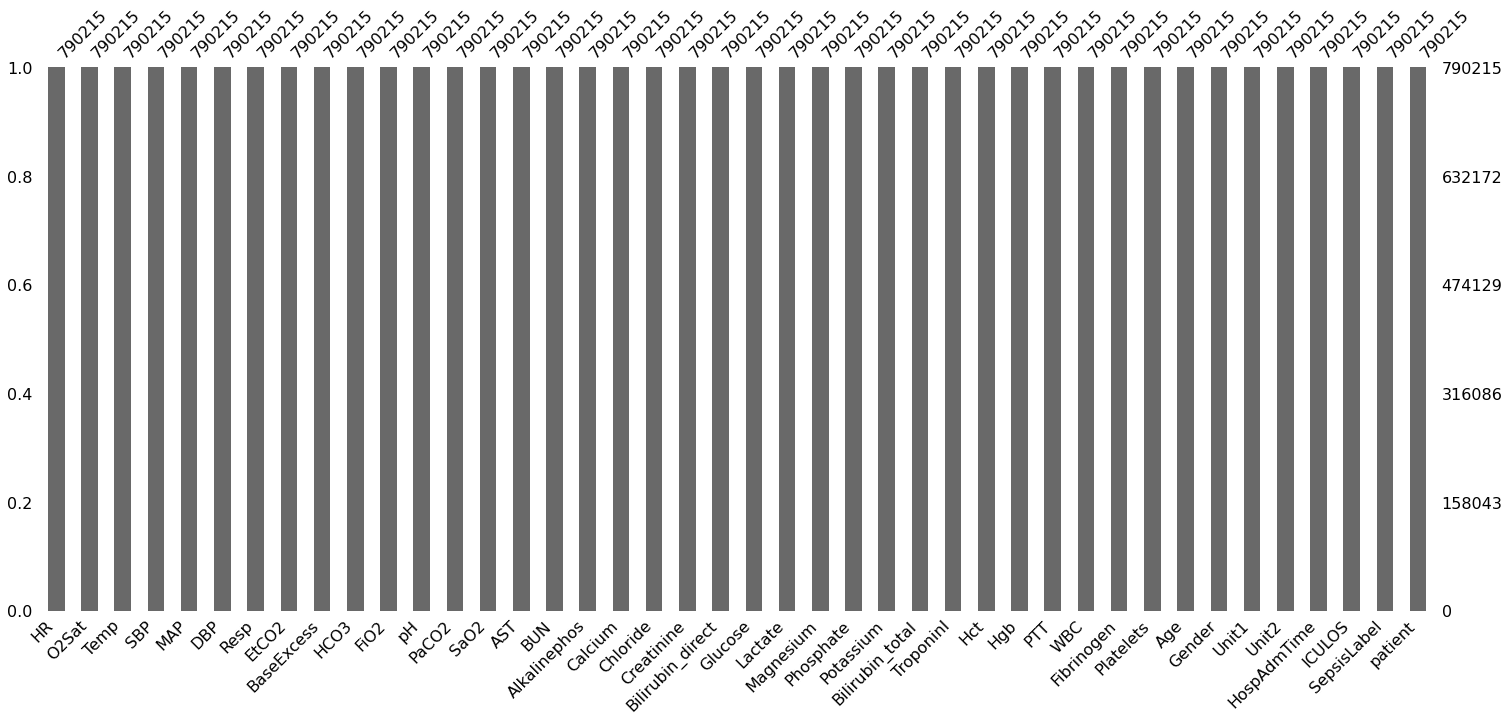

In [10]:
import missingno as msno
msno.bar(imputed_df)

Flatten 4 hours of imputed patient data

In [13]:
'''
Flaten 4hours of patient data into one patient.
'''

flat_imputed_df = flatten_dataset(imputed_df, hours = 4)
print(flat_imputed_df.shape)
print(flat_imputed_df.columns)
print(flat_imputed_df.head)

(186128, 144)
Index(['HR_0', 'O2Sat_0', 'Temp_0', 'SBP_0', 'MAP_0', 'DBP_0', 'Resp_0',
       'EtCO2_0', 'BaseExcess_0', 'HCO3_0',
       ...
       'Fibrinogen_3', 'Platelets_3', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient'],
      dtype='object', length=144)
<bound method NDFrame.head of          HR_0  O2Sat_0  Temp_0  SBP_0   MAP_0  DBP_0  Resp_0  EtCO2_0  \
0        97.0     95.0   36.11   98.0   75.33    0.0    19.0      0.0   
1       103.0     88.5   36.11  122.0   91.33    0.0    24.5      0.0   
2       104.0     95.0   36.11  133.0   88.33    0.0    26.0      0.0   
3       102.0     93.0   37.17  129.0   77.00    0.0    24.0      0.0   
4       103.0     90.0   36.56  132.0   96.67    0.0    30.0      0.0   
...       ...      ...     ...    ...     ...    ...     ...      ...   
189957   86.0     98.0   37.56  187.0  120.50  105.0    16.0      0.0   
189958   90.0     97.0   38.56  114.0   84.00   65.0    16.0      0.0   
18995

<AxesSubplot:>

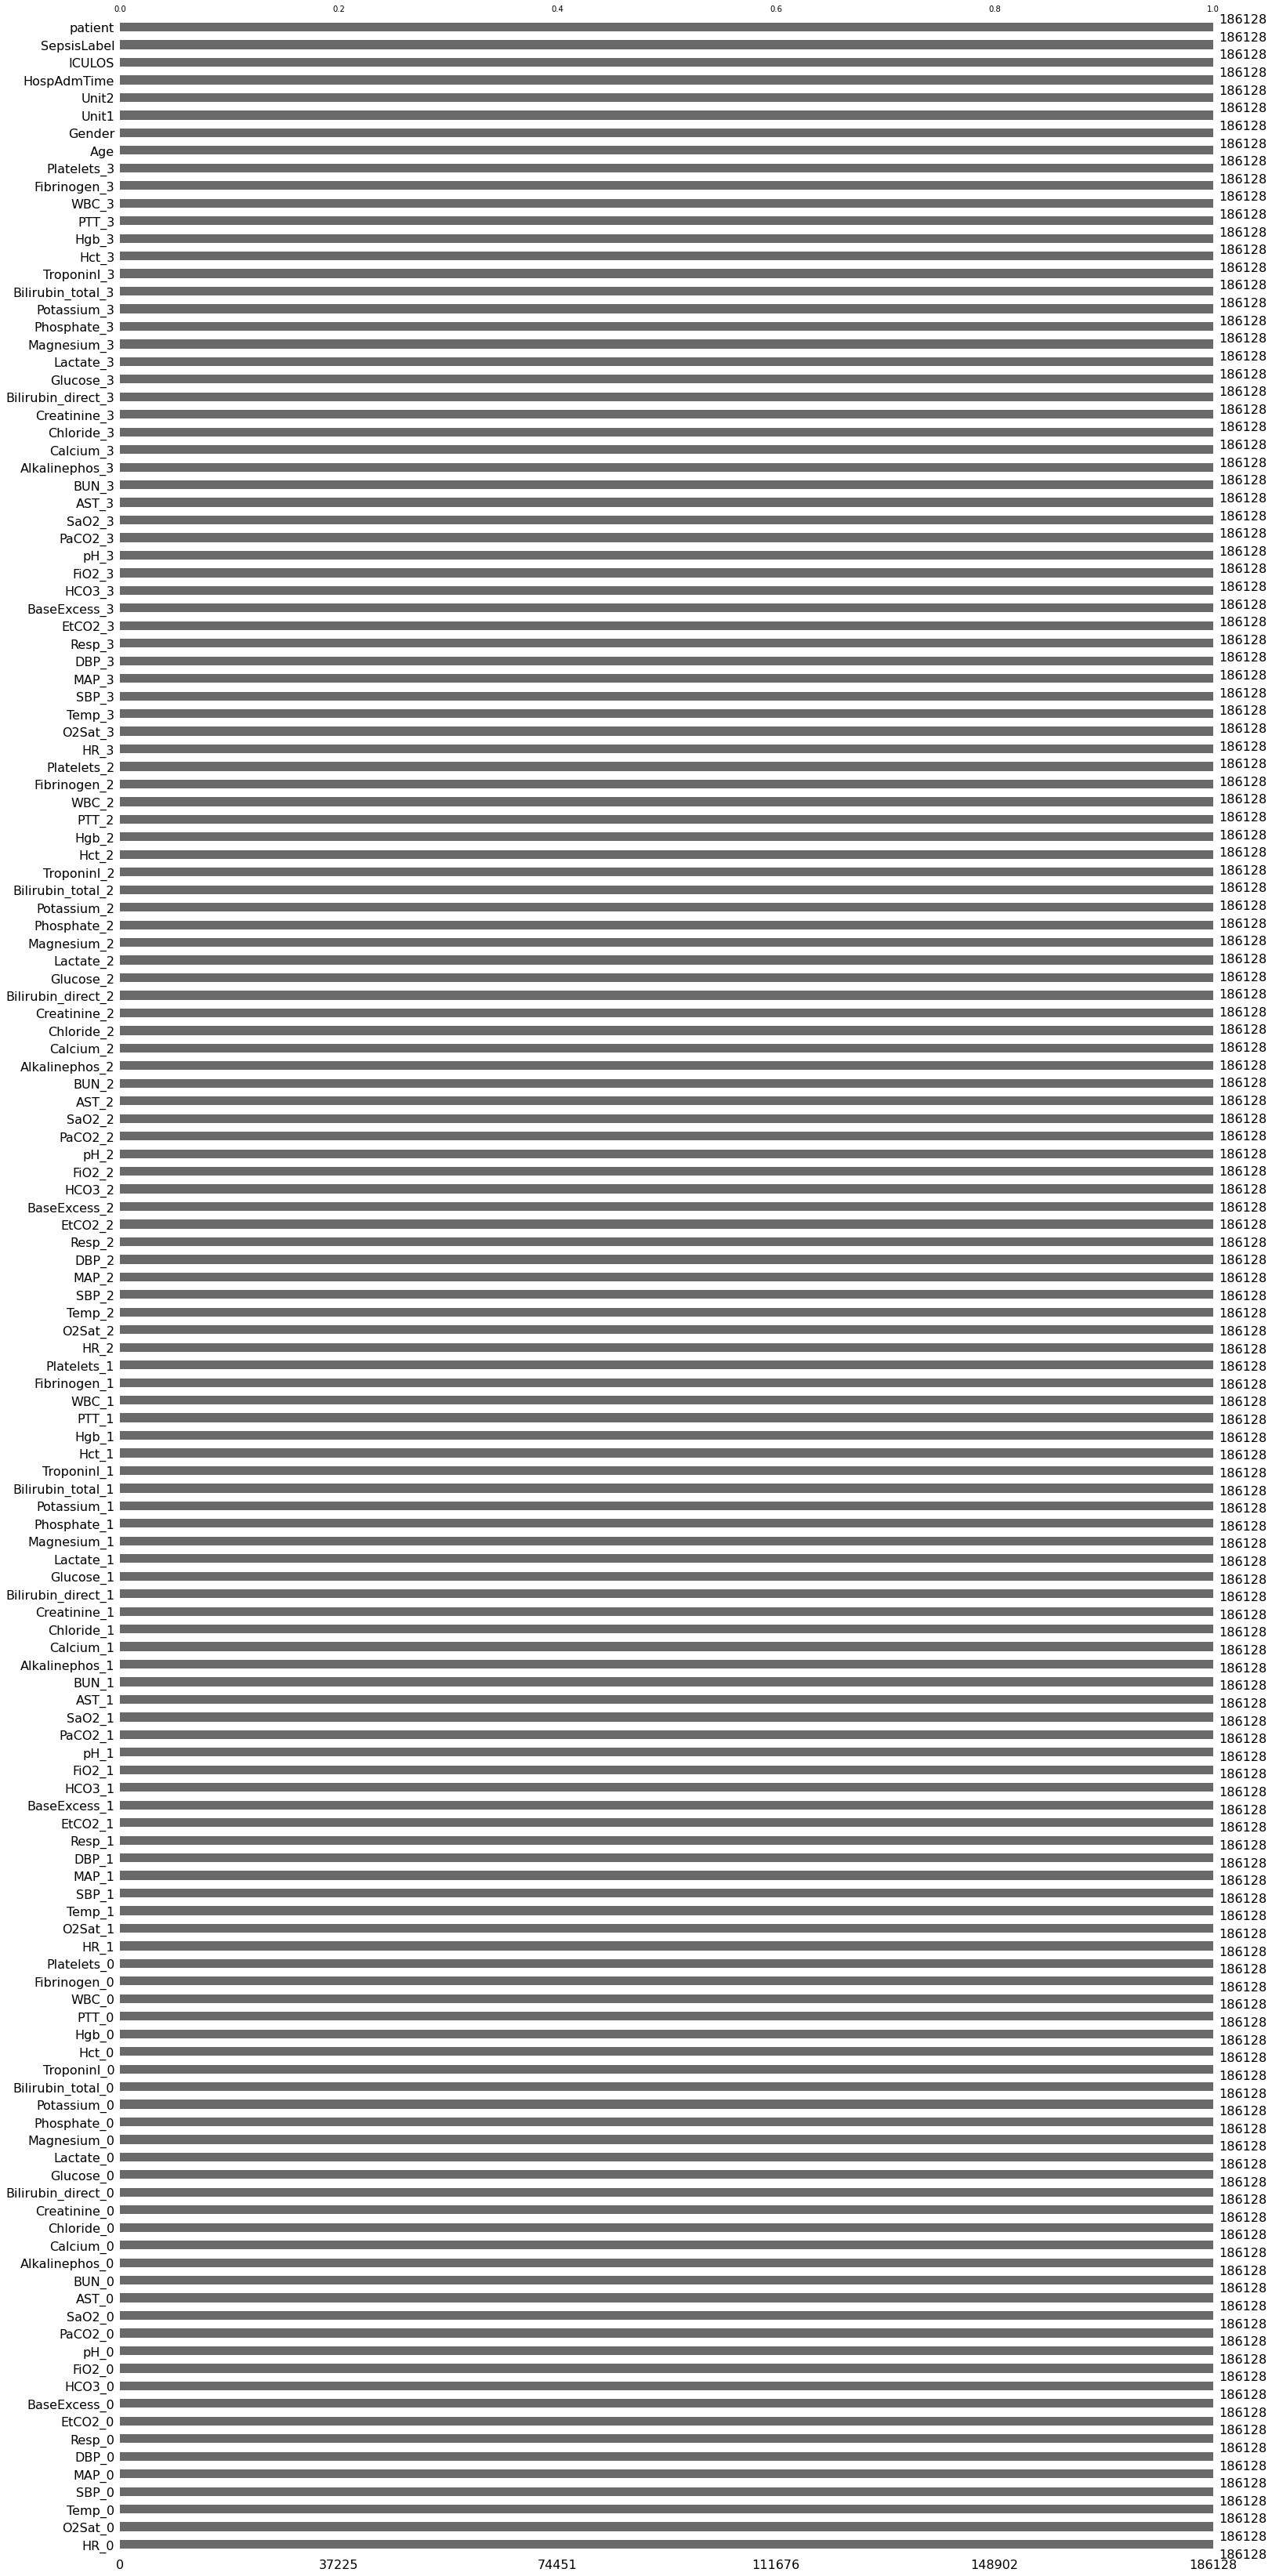

In [14]:
import missingno as msno
msno.bar(flat_imputed_df)

In [ ]:
#with open("data/flat_imputed_dataset.pkl", "rb") as f:
#    flat_imputed_df = pickle.load(f)

with open("data/flat_imputed_dataset.pkl", "wb") as f:
    pickle.dump(flat_imputed_df,f)